In [71]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import from_networkx
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from typing import List, Union
%matplotlib inline
import matplotlib.pyplot as plt

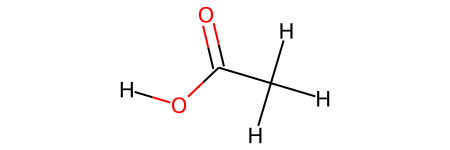

In [35]:
acetic_acid = 'CC(O)=O'

temp = Chem.MolFromSmiles(acetic_acid)
mol = Chem.AddHs(temp)
mol

In [36]:
ATOM_FEATURES = {
    'atomic_num': [1, 6, 8]
}
ATOM_FDIM = sum(len(choices) for choices in ATOM_FEATURES)

BOND_FDIM = 4

In [37]:
def get_OneHotEncoding(value: int, choices: List[int]) -> List[int]:
    encoding = [0] * (len(choices))
    index = choices.index(value)
    encoding[index] = 1

    return encoding

In [38]:
def get_atom_features(atom: Chem.rdchem.Atom, functional_groups: List[int] = None) -> List[Union[bool, int, float]]:
    if atom is None:
        features = [0] * ATOM_FDIM
    else:
        features = get_OneHotEncoding(atom.GetAtomicNum(), ATOM_FEATURES['atomic_num'])
    
    return features

In [39]:
def get_bond_features(bond: Chem.rdchem.Bond) -> List[Union[bool, int, float]]:
    if bond is None:
        fbond = [1] + [0] * (BOND_FDIM - 1)
    else:
        bt = bond.GetBondType()
        fbond = [0,
                 int(bt == Chem.rdchem.BondType.SINGLE),
                 int(bt == Chem.rdchem.BondType.DOUBLE),
                 int(bt == Chem.rdchem.BondType.TRIPLE),
                 int(bt == Chem.rdchem.BondType.AROMATIC),
                 int(bond.GetIsConjugated() if bt is not None else 0),
                 int(bond.IsInRing() if bt is not None else 0)
                 ]

    return fbond    

In [72]:
# Create graph for acetic acid
G = nx.Graph()

for atom in mol.GetAtoms():
    G.add_node(atom.GetIdx(), x=get_atom_features(atom))

for bond in mol.GetBonds():
    G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(),
    edge_attrs=get_bond_features(bond))

pyg_graph = from_networkx(G)


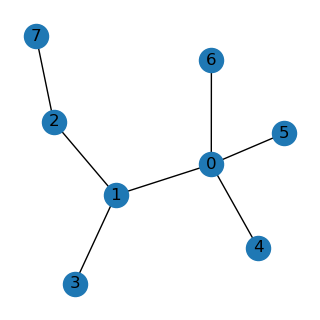

In [73]:
plt.figure(figsize=(3,3))

nx.draw(G, with_labels=True)

plt.show()

In [74]:
pyg_graph

Data(x=[8, 3], edge_index=[2, 14], edge_attrs=[14, 7])

In [75]:
pyg_graph.x

tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]])

In [76]:
pyg_graph.edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 4, 5, 6, 7],
        [1, 4, 5, 6, 0, 2, 3, 1, 7, 1, 0, 0, 0, 2]])

In [77]:
pyg_graph.edge_attrs

<bound method BaseData.edge_attrs of Data(x=[8, 3], edge_index=[2, 14], edge_attrs=[14, 7])>

In [78]:
conv1 = GCNConv(3, 3)

In [79]:
x = pyg_graph.x.float()
edge_index = pyg_graph.edge_index
edge_attrs = pyg_graph.edge_attrs

In [80]:
h = conv1(x, edge_index)
print(h)


tensor([[ 0.8480,  0.5930, -1.0149],
        [ 1.0088,  0.0613, -0.3960],
        [ 0.7803,  0.1857, -0.5202],
        [ 0.7736,  0.0367, -0.2950],
        [ 0.5191,  0.3800, -0.6163],
        [ 0.5191,  0.3800, -0.6163],
        [ 0.5191,  0.3800, -0.6163],
        [ 0.6811, -0.0293, -0.3274]], grad_fn=<AddBackward0>)


In [81]:
h = F.relu(h)
print(h)

tensor([[0.8480, 0.5930, 0.0000],
        [1.0088, 0.0613, 0.0000],
        [0.7803, 0.1857, 0.0000],
        [0.7736, 0.0367, 0.0000],
        [0.5191, 0.3800, 0.0000],
        [0.5191, 0.3800, 0.0000],
        [0.5191, 0.3800, 0.0000],
        [0.6811, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)


In [ ]:
h = 